<div class="alert alert-block alert-info" align=center><h1>Capstone Two Data Wrangling</h1></div>

<div class="alert alert-block alert-info"><b>We are going to look at two datasets. <br><br>
Area Health Resources provides data on the supply, distribution, and utilization of healthcare resources across the United States.
National Center for Health Statistics (NCHS) mortality data Can be used to analyze disparities in mortality rates across different geographic areas and population groups.<br><br>

For consideration is the necessary to add the American Community Survey (ACS) PUMS. The Public Use Microdata Sample (PUMS) contains a sample of actual responses to the American Community Survey (ACS). The PUMS dataset includes variables for nearly every question on the survey, as well as many new variables that were derived after the fact from multiple survey responses (such as poverty status).</b></div>

<div class="alert alert-block alert-info">Imports of the necessary packages 

In [1]:
#Import pandas, matplotlib.pyplot, seaborn, os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import re
import os
import gc

# This is giving me a problem. I will use pandas save function for now.
#from library.sb_utils import save_file

<div class="alert alert-block alert-info">Loading data for the first two datasets. 

In [2]:
def convert_parquet_float64_to_float16(parquet_file_path, output_parquet_path):
    """Converts a Parquet file with float64 columns to float16.

    Args:
        parquet_file_path: Path to the input Parquet file.
        output_parquet_path: Path to save the output Parquet file.
    """

    try:
        table = pq.read_table(parquet_file_path)
        new_arrays = []

        for i in range(table.num_columns):
            field = table.field(i)  # Get the Field object
            column = table.column(i)

            if column.type == pa.float64():
                np_array = column.to_numpy()
                new_np_array = np_array.astype(np.float16)
                new_array = pa.array(new_np_array)
                new_arrays.append(new_array.cast(pa.float16()))  # No with_name here

            else:
               new_arrays.append(column) #Keep original column if not float64

        # Create a new schema with the original field names
        new_fields = []
        for i in range(table.num_columns):
            field = table.field(i)
            new_fields.append(pa.field(field.name, new_arrays[i].type)) #Create new fields with correct type

        new_schema = pa.schema(new_fields)
        new_table = pa.Table.from_arrays(new_arrays, schema=new_schema) #Use new schema

        pq.write_table(new_table, output_parquet_path)
        print(f"Parquet file converted and saved to: {output_parquet_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

In [3]:
# Load the Area Health Resources data and NCHS mortality data 
ahrf_data = pd.read_csv('../data/raw/AHRF_Demographics_Dashboard_Download_2015-2019.csv')

input_file_mortality = '../data/raw/compiled_data.parquet'
output_file_mortality = '../data/raw/compiled_data_float16.parquet'

if not os.path.exists(output_file_mortality):  # Check if the output file exists
    print("Output file does not exist. Converting...")
    convert_parquet_float64_to_float16(input_file_mortality, output_file_mortality)
else:
    print("Output file already exists. Skipping conversion.")

mortality_data = pd.read_parquet('../data/raw/compiled_data.parquet')

Output file already exists. Skipping conversion.


In [4]:
#Verification (to check the data type and size)
table_after = pq.read_table(output_file_mortality)
print(table_after.schema)  # Check the data types of the columns
print(f"Size of the converted file: {table_after.nbytes} bytes")

year: halffloat
month: string
age_detail_number: halffloat
sex: string
place_of_death: halffloat
education1989: string
education2003: string
education_flag: string
all_icd: string
hisp_recode: halffloat
race_recode: halffloat
race_recode_alt: halffloat
race_recode_new: halffloat
agey: halffloat
Size of the converted file: 1736219789 bytes


In [5]:
table_before = pq.read_table(input_file_mortality)
print(f"Size of the original file: {table_before.nbytes} bytes")

Size of the original file: 3048393829 bytes


In [6]:
#Once a smaller file size is what we are working with, we drop th elarge file from memory and let gargage collector handle th erest. 
if table_before.nbytes > table_after.nbytes:
    print('Great')
    del table_before
    gc.collect() # encourage garbage collection
else: print('No So great')

Great


In [7]:
#View the summary of the AHRF data
ahrf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Area Health Resource Files Release Year            1924 non-null   object 
 1   Occupation Code                                    1924 non-null   object 
 2   Occupation Name                                    1924 non-null   object 
 3   Geography Code                                     1924 non-null   int64  
 4   Geography Abbreviation                             1924 non-null   object 
 5   Geography Name                                     1924 non-null   object 
 6   Total Count                                        1871 non-null   float64
 7   Hispanic or Latino (N)                             967 non-null    float64
 8   White* (N)                                         1851 non-null   float64
 9   Black or

In [8]:
#View the summary of the NCHS data
mortality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26779062 entries, 0 to 26779061
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   year               float64
 1   month              object 
 2   age_detail_number  float64
 3   sex                object 
 4   place_of_death     float64
 5   education1989      object 
 6   education2003      object 
 7   education_flag     object 
 8   all_icd            object 
 9   hisp_recode        float64
 10  race_recode        float64
 11  race_recode_alt    float64
 12  race_recode_new    float64
 13  agey               float64
dtypes: float64(8), object(6)
memory usage: 2.8+ GB


In [9]:
#print the first several row of each data
ahrf_data.head()

,Area Health Resource Files Release Year,Occupation Code,Occupation Name,Geography Code,Geography Abbreviation,Geography Name,Total Count,Hispanic or Latino (N),White* (N),Black or African American* (N),...,40 to 49 Years Old (%),50 to 59 Years Old (%),60 or Older (%),Male (%),Female (%),Missing or Suppressed Race/Ethnicity Data Comment,Missing or Suppressed Age Data Comment,Missing or Suppressed Gender Data Comment,HRSA Data Warehouse Processing Date,Unnamed: 39
0,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,1,AL,Alabama,4546.0,NaN,3989.0,418.0,...,24.747,21.755,7.567,18.918,81.082,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN,2022/03/21,NaN
1,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,2,AK,Alaska,765.0,NaN,643.0,NaN,...,30.065,NaN,17.124,NaN,98.954,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed,2022/03/21,NaN
2,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,4,AZ,Arizona,3952.0,478.0,2998.0,125.0,...,24.595,24.949,18.219,19.104,80.896,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21,NaN
3,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,5,AR,Arkansas,1849.0,NaN,1655.0,146.0,...,25.690,24.013,13.196,18.983,81.017,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN,2022/03/21,NaN
4,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,6,CA,California,13557.0,1364.0,7661.0,826.0,...,22.077,21.553,19.068,15.136,84.864,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21,NaN


<div class="alert alert-block alert-info">Checking the length (row count) of the two tables. 

In [10]:
mortality_data.shape[0]

26779062

In [11]:
ahrf_data.shape[0]

1924

In [12]:
mortality_data.tail()

,year,month,age_detail_number,sex,place_of_death,education1989,education2003,education_flag,all_icd,hisp_recode,race_recode,race_recode_alt,race_recode_new,agey
26779057,2022.0,09,74.0,M,1.0,None,4,1,C189_I490_A415_A499_C189_R628_I10_C80,0.0,NaN,1.0,1.0,74.0
26779058,2022.0,09,64.0,M,6.0,None,2,1,I461_I461,0.0,NaN,2.0,2.0,64.0
26779059,2022.0,09,32.0,M,2.0,None,3,1,V877_T149_V877,0.0,NaN,1.0,1.0,32.0
26779060,2022.0,09,70.0,M,4.0,None,4,1,I251_I509_I10_I251,0.0,NaN,2.0,2.0,70.0
26779061,2022.0,09,79.0,M,4.0,None,3,1,C901_C901_E149_D649_I64_F019_R53_L899_N19,0.0,NaN,1.0,1.0,79.0


In [13]:
ahrf_data.describe()

,Geography Code,Total Count,Hispanic or Latino (N),White* (N),Black or African American* (N),Asian* (N),Native Hawaiian or Other Pacific Islander* (N),American Indian or Alaska Native* (N),Other or Multiple Races* (N),Less than 30 Years Old (N),...,American Indian or Alaska Native* (%),Other or Multiple Races* (%),Less than 30 Years Old (%),30 to 39 Years Old (%),40 to 49 Years Old (%),50 to 59 Years Old (%),60 or Older (%),Male (%),Female (%),Unnamed: 39
count,1924.000000,1.871000e+03,967.000000,1.851000e+03,985.000000,875.000000,72.000000,261.000000,694.000000,1561.000000,...,260.000000,694.000000,1561.000000,1686.000000,1649.000000,1625.000000,1540.000000,1602.000000,1833.000000,0.0
mean,30.153846,1.632059e+04,3872.054809,1.003289e+04,4937.021320,2767.376000,552.236111,550.624521,906.829971,4288.074952,...,3.280585,3.099879,24.386322,26.623757,21.770582,18.902946,14.215232,28.969579,74.486318,NaN
std,17.714211,1.083616e+05,19843.548418,6.609566e+04,30536.575406,14772.725095,1081.364611,1617.391477,3800.160700,26012.360192,...,6.275035,3.363032,13.407798,8.213288,6.710659,7.064853,8.255183,21.307936,20.306304,NaN
min,1.000000,3.900000e+01,34.000000,3.400000e+01,36.000000,39.000000,26.000000,14.000000,26.000000,36.000000,...,0.059000,0.412000,2.404000,3.348000,2.199000,3.478000,1.429000,1.728000,6.327000,NaN
25%,16.750000,9.095000e+02,192.500000,7.250000e+02,242.000000,170.500000,133.750000,99.000000,120.000000,287.000000,...,0.356750,1.589250,15.404000,21.489500,17.571000,14.341000,8.185500,12.628250,65.844000,NaN
50%,29.500000,2.489000e+03,413.000000,1.955000e+03,585.000000,374.000000,214.000000,187.000000,224.500000,706.000000,...,0.856000,2.185500,21.808000,25.968500,21.539000,18.432000,12.766500,22.953500,80.426000,NaN
75%,42.500000,7.438500e+03,1429.000000,5.199000e+03,2089.000000,1090.500000,491.500000,378.000000,523.000000,2018.000000,...,4.060250,3.260250,32.274000,30.691500,25.000000,22.318000,18.224500,38.646000,89.832000,NaN
max,91.000000,3.276074e+06,346402.000000,2.296253e+06,730399.000000,296085.000000,6996.000000,16675.000000,63481.000000,632371.000000,...,74.603000,37.045000,100.000000,70.849000,78.049000,77.670000,66.399000,100.000000,100.000000,NaN


In [14]:
mortality_data.describe()

,year,age_detail_number,place_of_death,hisp_recode,race_recode,race_recode_alt,race_recode_new,agey
count,2.677906e+07,2.677906e+07,2.677906e+07,2.677906e+07,2.061426e+07,2.677906e+07,2.677906e+07,2.677906e+07
mean,2.018232e+03,7.316200e+01,3.596922e+00,3.211142e+00,1.441226e+00,5.885132e+00,4.225049e+00,7.306848e+01
std,2.587162e+00,2.110793e+01,2.045588e+00,5.586275e+01,8.908141e-01,6.671972e+01,5.296836e+01,2.048516e+01
min,2.014000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.902588e-06
25%,2.016000e+03,6.400000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.400000e+01
50%,2.018000e+03,7.600000e+01,4.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.600000e+01
75%,2.021000e+03,8.600000e+01,5.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,8.600000e+01
max,2.022000e+03,9.990000e+02,9.000000e+00,9.990000e+02,5.000000e+00,9.990000e+02,9.990000e+02,9.990000e+02


In [15]:
mortality_data.columns

Index(['year', 'month', 'age_detail_number', 'sex', 'place_of_death',
       'education1989', 'education2003', 'education_flag', 'all_icd',
       'hisp_recode', 'race_recode', 'race_recode_alt', 'race_recode_new',
       'agey'],
      dtype='object')

<div class="alert alert-block alert-info">Remove unwanted file from memory</div>

In [16]:
del mortality_data
#I will load it again when needed

In [17]:
ahrf_data.columns

Index(['Area Health Resource Files Release Year', 'Occupation Code',
       'Occupation Name', 'Geography Code', 'Geography Abbreviation',
       'Geography Name', 'Total Count', 'Hispanic or Latino (N)', 'White* (N)',
       'Black or African American* (N)', 'Asian* (N)',
       'Native Hawaiian or Other Pacific Islander* (N)',
       'American Indian or Alaska Native* (N)', 'Other or Multiple Races* (N)',
       'Less than 30 Years Old (N)', '30 to 39 Years Old (N)',
       '40 to 49 Years Old (N)', '50 to 59 Years Old (N)', '60 or Older (N)',
       'Male (N)', 'Female (N)', 'Hispanic or Latino (%)', 'White* (%)',
       'Black or African American* (%)', 'Asian* (%)',
       'Native Hawaiian or Other Pacific Islander* (%)',
       'American Indian or Alaska Native* (%)', 'Other or Multiple Races* (%)',
       'Less than 30 Years Old (%)', '30 to 39 Years Old (%)',
       '40 to 49 Years Old (%)', '50 to 59 Years Old (%)', '60 or Older (%)',
       'Male (%)', 'Female (%)',
       'M

<div class="alert alert-block alert-info">Let's explore the data. This step will focus on one dataset at a time, starting with the AHRF data. 
The goal is to identify possible areas of connection between the two datasets and delve deeper to address our hypothesis.

<div class="alert alert-block alert-info">Number of missing values by column

<div class="alert alert-block alert-info">Filter out column African Amarican / Balck race as the race of interest. 

In [18]:
# Filter on Column Black or African American* (N) and transpose for easy viewing. 
#This is to isolate any person who identifies as fully or partially a member of the race
ahrfB_data = ahrf_data[ahrf_data['Black or African American* (N)'].isna()].T
ahrfB_data

,1,5,11,12,14,15,16,17,19,23,...,1911,1912,1913,1914,1916,1917,1919,1920,1921,1922
Area Health Resource Files Release Year,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,...,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019
Occupation Code,D3256,D3256,D3256,D3256,D3256,D3256,D3256,D3256,D3256,D3256,...,D3648,D3648,D3648,D3648,D3648,D3648,D3648,D3648,D3648,D3648
Occupation Name,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...
Geography Code,2,8,15,16,18,19,20,21,23,27,...,44,45,46,47,49,50,53,54,55,56
Geography Abbreviation,AK,CO,HI,ID,IN,IA,KS,KY,ME,MN,...,RI,SC,SD,TN,UT,VT,WA,WV,WI,WY
Geography Name,Alaska,Colorado,Hawaii,Idaho,Indiana,Iowa,Kansas,Kentucky,Maine,Minnesota,...,Rhode Island,South Carolina,South Dakota,Tennessee,Utah,Vermont,Washington,West Virginia,Wisconsin,Wyoming
Total Count,765.0,3118.0,449.0,1063.0,4348.0,2147.0,2183.0,4347.0,1419.0,4917.0,...,NaN,651.0,264.0,1393.0,174.0,250.0,2689.0,413.0,1524.0,NaN
Hispanic or Latino (N),NaN,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,120.0,NaN,NaN,287.0,NaN,NaN,NaN
White* (N),643.0,2845.0,169.0,1043.0,4194.0,1979.0,2064.0,4192.0,1419.0,4707.0,...,NaN,542.0,195.0,1139.0,161.0,250.0,2123.0,385.0,1401.0,NaN
Black or African American* (N),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Missing values by column
missing = pd.concat([ahrf_data.isnull().sum(), 100 * ahrf_data.isnull().mean()],axis = 1)
missing.columns=['count','%']
missing.sort_values('count',ascending=False)


,count,%
Unnamed: 39,1924,100.000000
Native Hawaiian or Other Pacific Islander* (N),1852,96.257796
Native Hawaiian or Other Pacific Islander* (%),1852,96.257796
American Indian or Alaska Native* (%),1664,86.486486
American Indian or Alaska Native* (N),1663,86.434511
Missing or Suppressed Gender Data Comment,1574,81.808732
Missing or Suppressed Age Data Comment,1327,68.970894
Other or Multiple Races* (N),1230,63.929314
Other or Multiple Races* (%),1230,63.929314
Asian* (%),1049,54.521830


In [20]:
missing['count'].sum()

np.int64(24393)

In [21]:
non_missing = pd.concat([ahrf_data.notnull().sum(), 100 * ahrf_data.notnull().mean()],axis = 1)
non_missing.columns=['count','%']
total_count = missing['count'].sum() + non_missing['count'].sum()
total_count


np.int64(76960)

<div class="alert alert-block alert-info">About 32% of the data is missing. It is essential to understand what is missing and why. 
However, the count here included NaN, which do not have to be imputed if we can identify that the NaN values are for
people who self-identify with another race. We also don't need to worry about categorical features. 


In [22]:
ahrf_data.dtypes

Area Health Resource Files Release Year               object
Occupation Code                                       object
Occupation Name                                       object
Geography Code                                         int64
Geography Abbreviation                                object
Geography Name                                        object
Total Count                                          float64
Hispanic or Latino (N)                               float64
White* (N)                                           float64
Black or African American* (N)                       float64
Asian* (N)                                           float64
Native Hawaiian or Other Pacific Islander* (N)       float64
American Indian or Alaska Native* (N)                float64
Other or Multiple Races* (N)                         float64
Less than 30 Years Old (N)                           float64
30 to 39 Years Old (N)                               float64
40 to 49 Years Old (N)  

In [23]:
#Identify categorical features - we will not worry about imputing NaN or Null for now. 
ahrf_data.select_dtypes('object')

,Area Health Resource Files Release Year,Occupation Code,Occupation Name,Geography Abbreviation,Geography Name,Missing or Suppressed Race/Ethnicity Data Comment,Missing or Suppressed Age Data Comment,Missing or Suppressed Gender Data Comment,HRSA Data Warehouse Processing Date
0,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,AL,Alabama,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN,2022/03/21
1,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,AK,Alaska,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed,2022/03/21
2,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,AZ,Arizona,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21
3,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,AR,Arkansas,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN,2022/03/21
4,ACS 5-Year 2015-2019,D3256,Advanced Practice Registered Nurses (excl. Cli...,CA,California,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21
...,...,...,...,...,...,...,...,...,...
1919,ACS 5-Year 2015-2019,D3648,Veterinary Assistants & Laboratory Animal Care...,WA,Washington,Black (Non-Hispanic): Supressed; Asian (Non-Hi...,60 or Older: Supressed,NaN,2022/03/21
1920,ACS 5-Year 2015-2019,D3648,Veterinary Assistants & Laboratory Animal Care...,WV,West Virginia,Hispanic: Supressed; Black (Non-Hispanic): [No...,40 to 49 Years Old: Supressed; 50 to 59 Years ...,Male: Supressed,2022/03/21
1921,ACS 5-Year 2015-2019,D3648,Veterinary Assistants & Laboratory Animal Care...,WI,Wisconsin,Hispanic: Supressed; Black (Non-Hispanic): [No...,50 to 59 Years Old: Supressed; 60 or Older: Su...,NaN,2022/03/21
1922,ACS 5-Year 2015-2019,D3648,Veterinary Assistants & Laboratory Animal Care...,WY,Wyoming,Total Count: Supressed; Hispanic: [No Data]; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: Supressed; Femal...,2022/03/21


<div class="alert alert-block alert-info">Occupation Counts

In [24]:
ahrf_data['Occupation Code'].value_counts().tail(20)

Occupation Code
D3150    52
D3610    52
D3520    52
D3040    52
D3602    52
D3050    52
D3647    52
D3649    52
D3620    52
D3160    52
D3110    52
D3090    52
D3120    52
D1821    52
D3255    52
D3220    52
D2011    52
D3230    52
D3250    52
D3648    52
Name: count, dtype: int64

In [25]:
ahrf_data['Occupation Code'].nunique()

37

<div class="alert alert-block alert-info">There seems to be an even distribution among all occupation codes

<div class="alert alert-block alert-info">Distribution of Occupation by Gender and Race

<div class="alert alert-block alert-info">First, create a varialbe to store gender count<br>
Second, Create a column for race

In [26]:
#Gender count
gender_count = ahrf_data[['Male (N)','Female (N)']].sum()
gender_count

Male (N)       6376034.0
Female (N)    24145207.0
dtype: float64

In [27]:
#Race representation count
race_col_names = ['Hispanic or Latino (N)', 'White* (N)',
       'Black or African American* (N)', 'Asian* (N)',
       'Native Hawaiian or Other Pacific Islander* (N)',
       'American Indian or Alaska Native* (N)', 'Other or Multiple Races* (N)']
#Find the Race representation
race_counts = ahrf_data[race_col_names].sum()
race_counts = race_counts.sort_values(ascending=False)

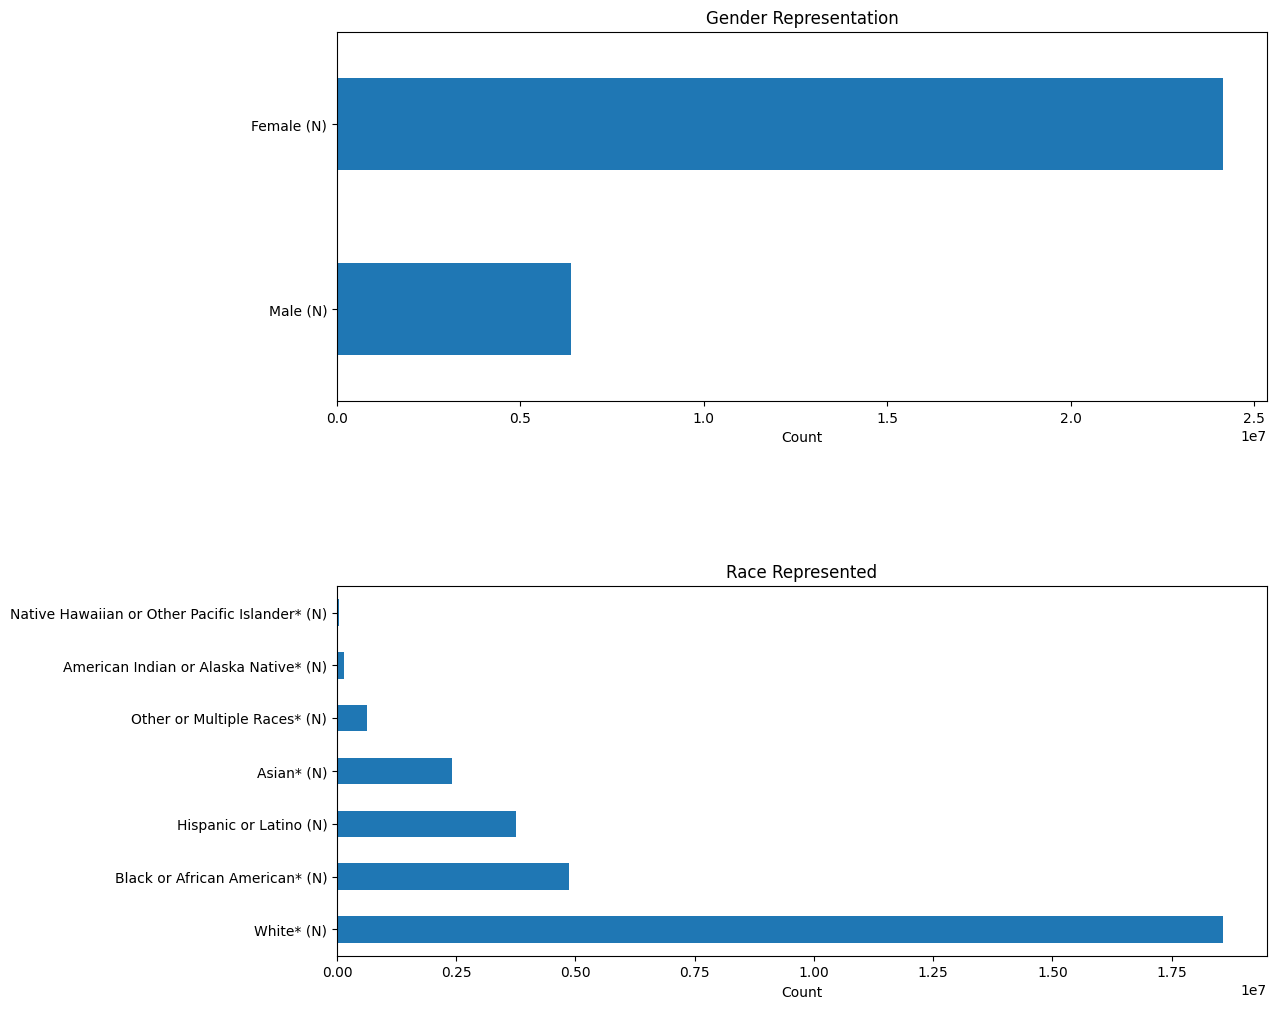

In [28]:
#Create two subplots on 2 row and 1 columns with a figsize of (12, 12)
fig, ax = plt.subplots(2,1, figsize=(12,12))
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
#ahrf_data.Gender.value_counts().plot(kind='barh', ax=ax[0])
gender_count.plot(kind='barh', ax=ax[0])
#plt.subplots_adjust(left=0.2)
#Give the plot a helpful title of 'Gender Representation'
ax[0].set_title('Gender Representation')
#Label the xaxis 'Count'
ax[0].set_xlabel('Count')
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
race_counts.plot(kind='barh', ax=ax[1])
#Give the plot a helpful title of 'Least Represented Race'
ax[1].set_title('Race Represented')
#Label the xaxis 'Count'
ax[1].set_xlabel('Count')


#Give the subplots a little "breathing room" with a hpace of 0.5
#plt.subplots_adjust(wspace=0.5);
plt.subplots_adjust(hspace=0.5);
#You're encouraged to explore a few different figure sizes, orientations, and spacing here
# as the importance of easy-to-read and informative figures is frequently understated
# and you will find the ability to tweak figures invaluable later on

<div class="alert alert-block alert-info">Average Male and Female count by Occupation 

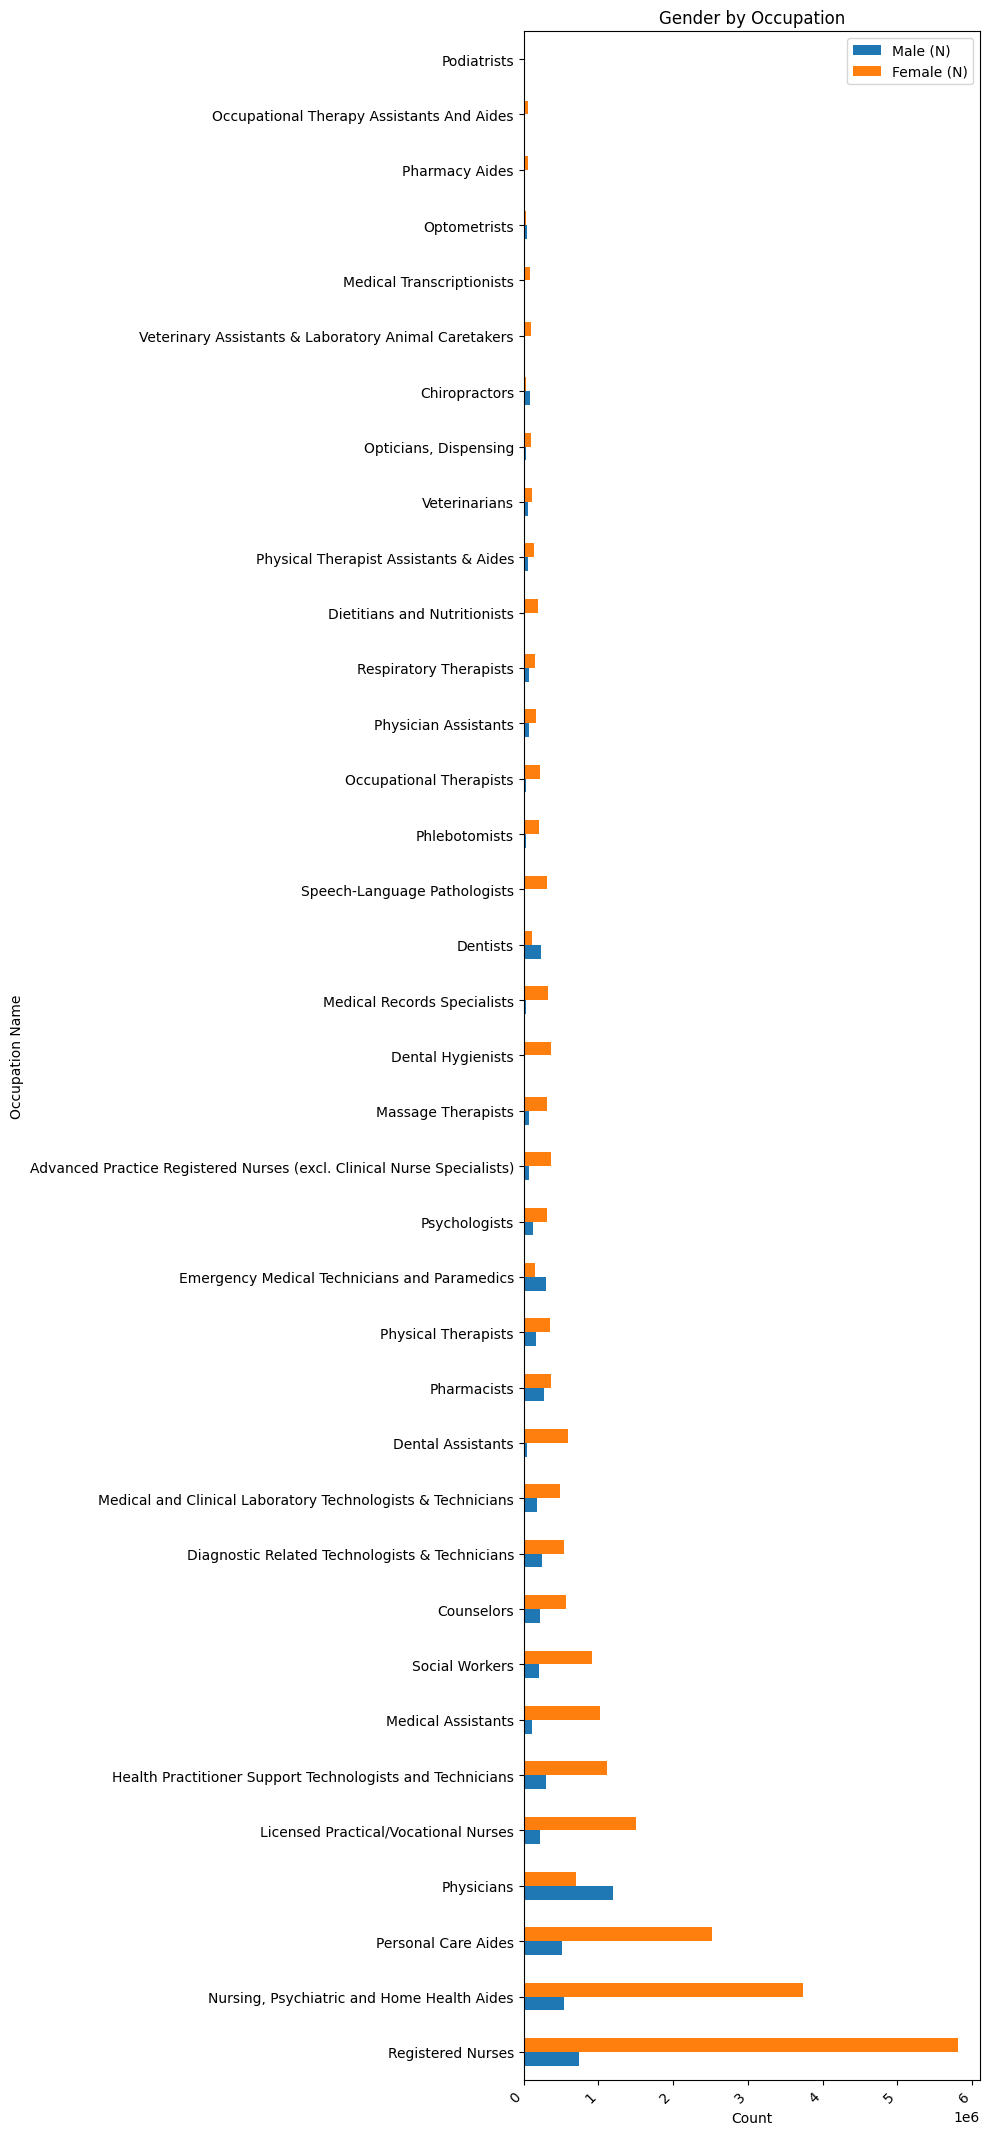

In [29]:
occupationN_gender_count= ahrf_data.groupby('Occupation Name')[['Male (N)','Female (N)']].sum()

# Sort the DataFrame by the sum of the gender columns (if needed)
occupationN_gender_count = occupationN_gender_count.reindex(
    index=occupationN_gender_count.sum(axis=1)
    .sort_values(ascending=False)
    .index
)

# Calculate the dynamic figure size (adjust height based on the number of occupations)
num_occupations = len(occupationN_gender_count)
fig_height = num_occupations * 0.58 # Adjust the multiplier as needed

# Create the plot with dynamic size
fig, ax = plt.subplots(figsize=(10, fig_height))

# Plot the data
occupationN_gender_count.plot(kind='barh', ax=ax, title='Gender by Occupation')

# Label the x-axis
ax.set_xlabel('Count')

# Rotate the x-axis labels if they are too long
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()



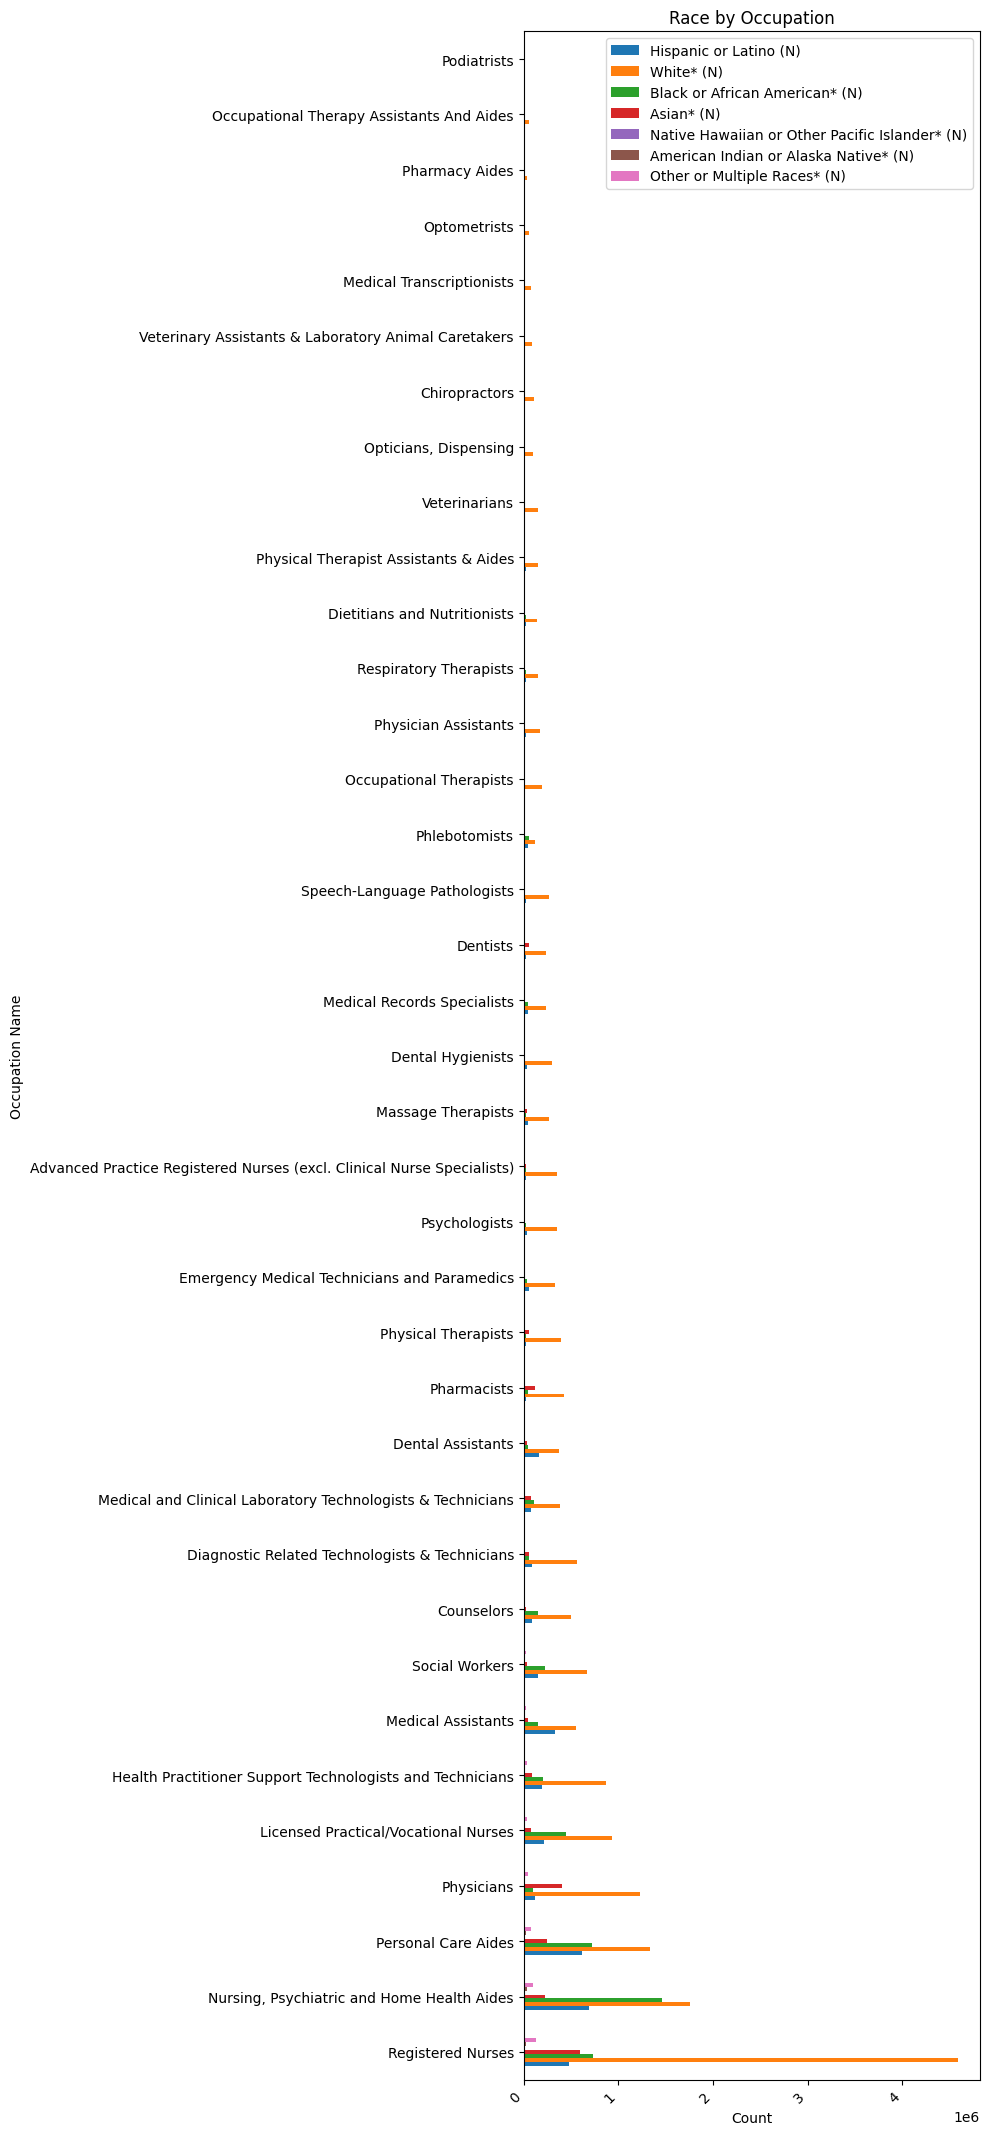

In [30]:
#Repeat above for race
occupationN_race_count = ahrf_data.groupby('Occupation Name')[race_col_names].sum()

# Sort the DataFrame by the sum of the race columns (if needed)
occupationN_race_count = occupationN_race_count.reindex(
    index=occupationN_race_count.sum(axis=1)
    .sort_values(ascending=False)
    .index
)

# Calculate the dynamic figure size (adjust height based on the number of occupations)
num_occupations = len(occupationN_race_count)
fig_height = num_occupations * 0.58 # Adjust the multiplier as needed

# Create the plot with dynamic size
fig, ax = plt.subplots(figsize=(10, fig_height))

# Plot the data
occupationN_race_count.plot(kind='barh', ax=ax, title='Race by Occupation')

# Label the x-axis
ax.set_xlabel('Count')

# Rotate the x-axis labels if they are too long
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [31]:
#Use the pd.melt function, pass in the ahrf_data columns 'Geographic Name', 'Male (N)', and 'Female (N)' only,
#specify 'Geographic Name' for `id_vars`
#gather the count from the 'Male (N)' and 'Female (N)' columns using the `value_vars` argument,
#call the resultant price column 'Count' via the `value_name` argument,
#name the gender indicator column 'Gender' via the `var_name` argument

gender_representation = pd.melt(ahrf_data[['Geography Name','Male (N)','Female (N)', 'Occupation Code']], 
                        id_vars=['Geography Name', 'Occupation Code'], 
                        var_name='Gender', 
                        value_vars=['Male (N)','Female (N)'], 
                        value_name='Count',)

#sort the melt
gender_representation = gender_representation.sort_values('Occupation Code')
# I want to explore group by occupation before melt         

In [32]:
gender_representation.tail()

,Geography Name,Occupation Code,Gender,Count
3200,Nevada,D3649,Female (N),1287.0
3199,Nebraska,D3649,Female (N),779.0
3198,Montana,D3649,Female (N),232.0
1299,All States,D3649,Male (N),17602.0
3222,Wyoming,D3649,Female (N),101.0


In [33]:
#Repeating same for race representation
race_representation = pd.melt(ahrf_data, 
                        id_vars=['Geography Name', 'Occupation Code'], 
                        value_vars=race_col_names, 
                        var_name='Race',
                        value_name='count',)
#sort the melt
race_representation = race_representation.sort_values('Geography Name')

In [34]:
race_representation.tail()

,Geography Name,Occupation Code,Race,count
466,Wyoming,D3401,Hispanic or Latino (N),NaN
5666,Wyoming,D3230,Black or African American* (N),NaN
1558,Wyoming,D3120,Hispanic or Latino (N),NaN
5926,Wyoming,D2001,Asian* (N),NaN
13102,Wyoming,D3120,Other or Multiple Races* (N),NaN


In [35]:
gender_representation.head()

,Geography Name,Occupation Code,Gender,Count
3507,Minnesota,D1821,Female (N),4451.0
1581,Massachusetts,D1821,Male (N),2673.0
1580,Maryland,D1821,Male (N),1351.0
1579,Maine,D1821,Male (N),187.0
1578,Louisiana,D1821,Male (N),334.0


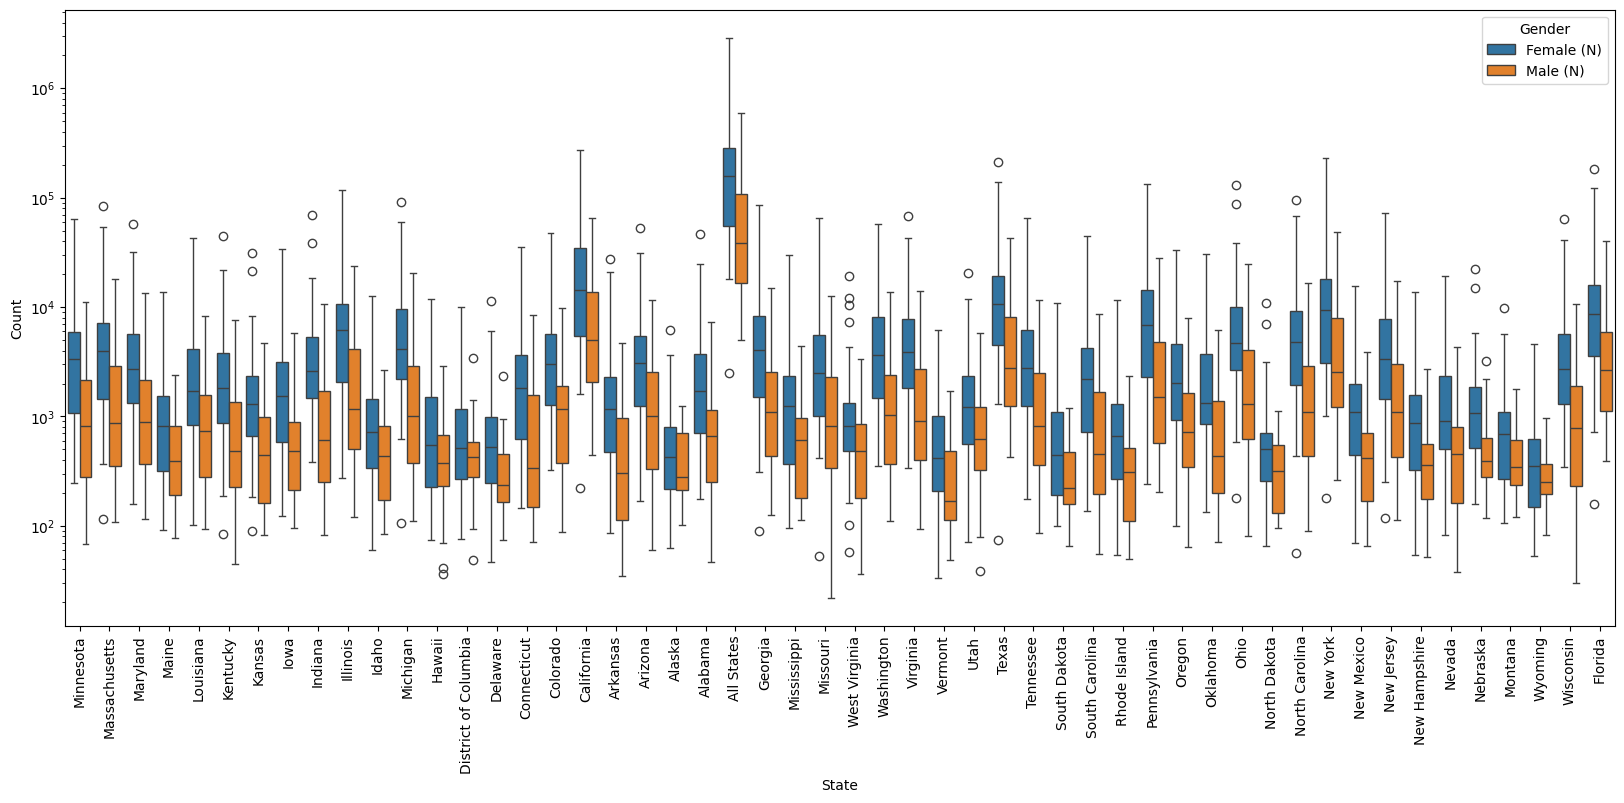

In [36]:
#Create a seaborn boxplot of the gender count dataframe we created above,
#with 'Geographic Name' on the x-axis, 'Count' as the y-value, and a hue that indicates 'Gender'
#This will use boxplot's x, y, hue, and data arguments.
#using log scale to make chart readable.
plt.subplots(figsize=(20, 8))
sns.boxplot(x='Geography Name', y='Count', hue='Gender', data=gender_representation, log_scale=True)
plt.xticks(rotation='vertical')
plt.ylabel('Count')
plt.xlabel('State');

We can see outlier. Are htese good or bad? Do we need to drop them? Further investigation is necessary

In [37]:
#Numeric Features
ahrf_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Geography Code,1924.0,30.153846,17.714211,1.000,16.75000,29.5000,42.50000,91.000
Total Count,1871.0,16320.588990,108361.596483,39.000,909.50000,2489.0000,7438.50000,3276074.000
Hispanic or Latino (N),967.0,3872.054809,19843.548418,34.000,192.50000,413.0000,1429.00000,346402.000
White* (N),1851.0,10032.891950,66095.662613,34.000,725.00000,1955.0000,5199.00000,2296253.000
Black or African American* (N),985.0,4937.021320,30536.575406,36.000,242.00000,585.0000,2089.00000,730399.000
Asian* (N),875.0,2767.376000,14772.725095,39.000,170.50000,374.0000,1090.50000,296085.000
Native Hawaiian or Other Pacific Islander* (N),72.0,552.236111,1081.364611,26.000,133.75000,214.0000,491.50000,6996.000
American Indian or Alaska Native* (N),261.0,550.624521,1617.391477,14.000,99.00000,187.0000,378.00000,16675.000
Other or Multiple Races* (N),694.0,906.829971,3800.160700,26.000,120.00000,224.5000,523.00000,63481.000
Less than 30 Years Old (N),1561.0,4288.074952,26012.360192,36.000,287.00000,706.0000,2018.00000,632371.000


<div class="alert alert-block alert-info">Finding Missing Values for Gender

In [38]:
missing_gender = ahrf_data[['Male (N)','Female (N)']].isnull().sum(axis=1)
missing_gender.value_counts()/len(missing_gender) * 100

0    81.808732
1    14.968815
2     3.222453
Name: count, dtype: float64

<div class="alert alert-block alert-info">82% of data has a value for gender. About 15% is missing one value, either Male or Female. About 3% is missing both values.
Should we consider dropping when both are missing? To be analyzed further

<div class="alert alert-block alert-info">Doing the same for race

In [39]:
#Using the above defined race column names
missing_race = ahrf_data[race_col_names].isnull().sum(axis=1)
missing_race.value_counts()/len(missing_race) * 100

6    29.573805
2    17.983368
5    15.696466
3    11.746362
4    11.538462
1     8.004158
7     3.170478
0     2.286902
Name: count, dtype: float64

<div class="alert alert-block alert-info">Only about 3% of the data is missing all seven races. This is a good sign. We need at least one of the columns to have data. 
Can we drop the 3%?

<div class="alert alert-block alert-info"><h3> Now that we know about 3% of gender and 3% of race values are missing, let's check if these occur in the same row. </h3></div>

In [40]:
# List of gender-related columns
gender_cols = ['Male (N)', 'Female (N)']

# Find rows where all race columns are NaN
race_null_rows = ahrf_data[race_col_names].isna().all(axis=1)

# Find rows where Male and Female are also NaN
gender_null_rows = ahrf_data[gender_cols].isna().all(axis=1)

# Combine both conditions
rows_to_check = ahrf_data[race_null_rows & gender_null_rows]
rows_to_check.sample(10)

,Area Health Resource Files Release Year,Occupation Code,Occupation Name,Geography Code,Geography Abbreviation,Geography Name,Total Count,Hispanic or Latino (N),White* (N),Black or African American* (N),...,40 to 49 Years Old (%),50 to 59 Years Old (%),60 or Older (%),Male (%),Female (%),Missing or Suppressed Race/Ethnicity Data Comment,Missing or Suppressed Age Data Comment,Missing or Suppressed Gender Data Comment,HRSA Data Warehouse Processing Date,Unnamed: 39
1508,ACS 5-Year 2015-2019,D3120,Podiatrists,1,AL,Alabama,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: [No Data]; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: [No Data]; Femal...,2022/03/21,NaN
1085,ACS 5-Year 2015-2019,D3040,Optometrists,50,VT,Vermont,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: Supressed; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: Supressed; Femal...,2022/03/21,NaN
1246,ACS 5-Year 2015-2019,D3647,Pharmacy Aides,56,WY,Wyoming,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: [No Data]; Hispanic: [No Data]; W...,Total Count: [No Data]; Less than 30 Years Old...,Total Count: [No Data]; Male: [No Data]; Femal...,2022/03/21,NaN
1515,ACS 5-Year 2015-2019,D3120,Podiatrists,10,DE,Delaware,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: Supressed; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: Supressed; Femal...,2022/03/21,NaN
60,ACS 5-Year 2015-2019,D3000,Chiropractors,11,DC,District of Columbia,73.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hispanic: [No Data]; White (Non-Hispanic): Sup...,Less than 30 Years Old: [No Data]; 30 to 39 Ye...,Male: Supressed; Female: Supressed,2022/03/21,NaN
1230,ACS 5-Year 2015-2019,D3647,Pharmacy Aides,38,ND,North Dakota,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: [No Data]; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: [No Data]; Femal...,2022/03/21,NaN
1203,ACS 5-Year 2015-2019,D3647,Pharmacy Aides,10,DE,Delaware,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: [No Data]; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: [No Data]; Femal...,2022/03/21,NaN
1526,ACS 5-Year 2015-2019,D3120,Podiatrists,22,LA,Louisiana,84.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Hispanic: [No Data]; White (Non-Hispanic): Sup...,Less than 30 Years Old: [No Data]; 30 to 39 Ye...,Male: Supressed; Female: Supressed,2022/03/21,NaN
1207,ACS 5-Year 2015-2019,D3647,Pharmacy Aides,15,HI,Hawaii,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: [No Data]; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: [No Data]; Femal...,2022/03/21,NaN
986,ACS 5-Year 2015-2019,D3610,Occupational Therapy Assistants And Aides,56,WY,Wyoming,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Total Count: Supressed; Hispanic: Supressed; W...,Total Count: Supressed; Less than 30 Years Old...,Total Count: Supressed; Male: [No Data]; Femal...,2022/03/21,NaN


<div class="alert alert-block alert-info"><h3> The above shows that we still have about 6% missing in either gender or race. If we drop gender, we lose potentially valuable race data, and vice versa. </h3>
<h4>We will drop the 55 rows where all race and gender values are missing</h4>

The "Total Count" column is going to skew the data. We are going to drop it as well. </div>

In [41]:
ahrf_data = ahrf_data.drop(rows_to_check.index)
ahrf_noTotal = ahrf_data.drop('Total Count',axis=1)

<div class="alert alert-block alert-info"><h3> Distribution of feature values</h3></div>

In [42]:
def plot_numeric_histograms(df, bins=5, max_cols=5, figsize=(35, 50)):
    """
    Plots histograms for all numeric columns in a Pandas DataFrame, 
    highlighting the mean with a vertical line.

    Args:
        df: The Pandas DataFrame.
        bins: The number of bins for the histograms (default: 5).
        max_cols: The maximum number of columns per row of plots (default: 5).
        figsize: The figure size (default: (35, 50)).

    Returns:
        None. Displays the plot.
    """

    num_features = df.select_dtypes(include=['number']).columns

    # Remove columns where all values are NaN
    valid_columns = [col for col in num_features if df[col].dropna().size > 0]

    n_cols = min(max_cols, len(valid_columns))
    n_rows = (len(valid_columns) // n_cols) + (len(valid_columns) % n_cols > 0)  # Corrected calculation

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    axes = axes.flatten()

    for ax, col in zip(axes, valid_columns):
        if '_%' in col:
            valid_data = df[col].dropna() / 100
        else:
            valid_data = df[col].dropna()
        mean_value = valid_data.mean()
        ax.hist(valid_data, bins=bins, alpha=0.7, edgecolor='blue')
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
        ax.set_title(f'{col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.legend([f'Mean: {mean_value:.2f}'], loc='upper right')

    # Hide any remaining empty axes.  Important to use valid_columns now.
    for ax in axes[len(valid_columns):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=1.5)
    plt.show() # Explicitly show the plot


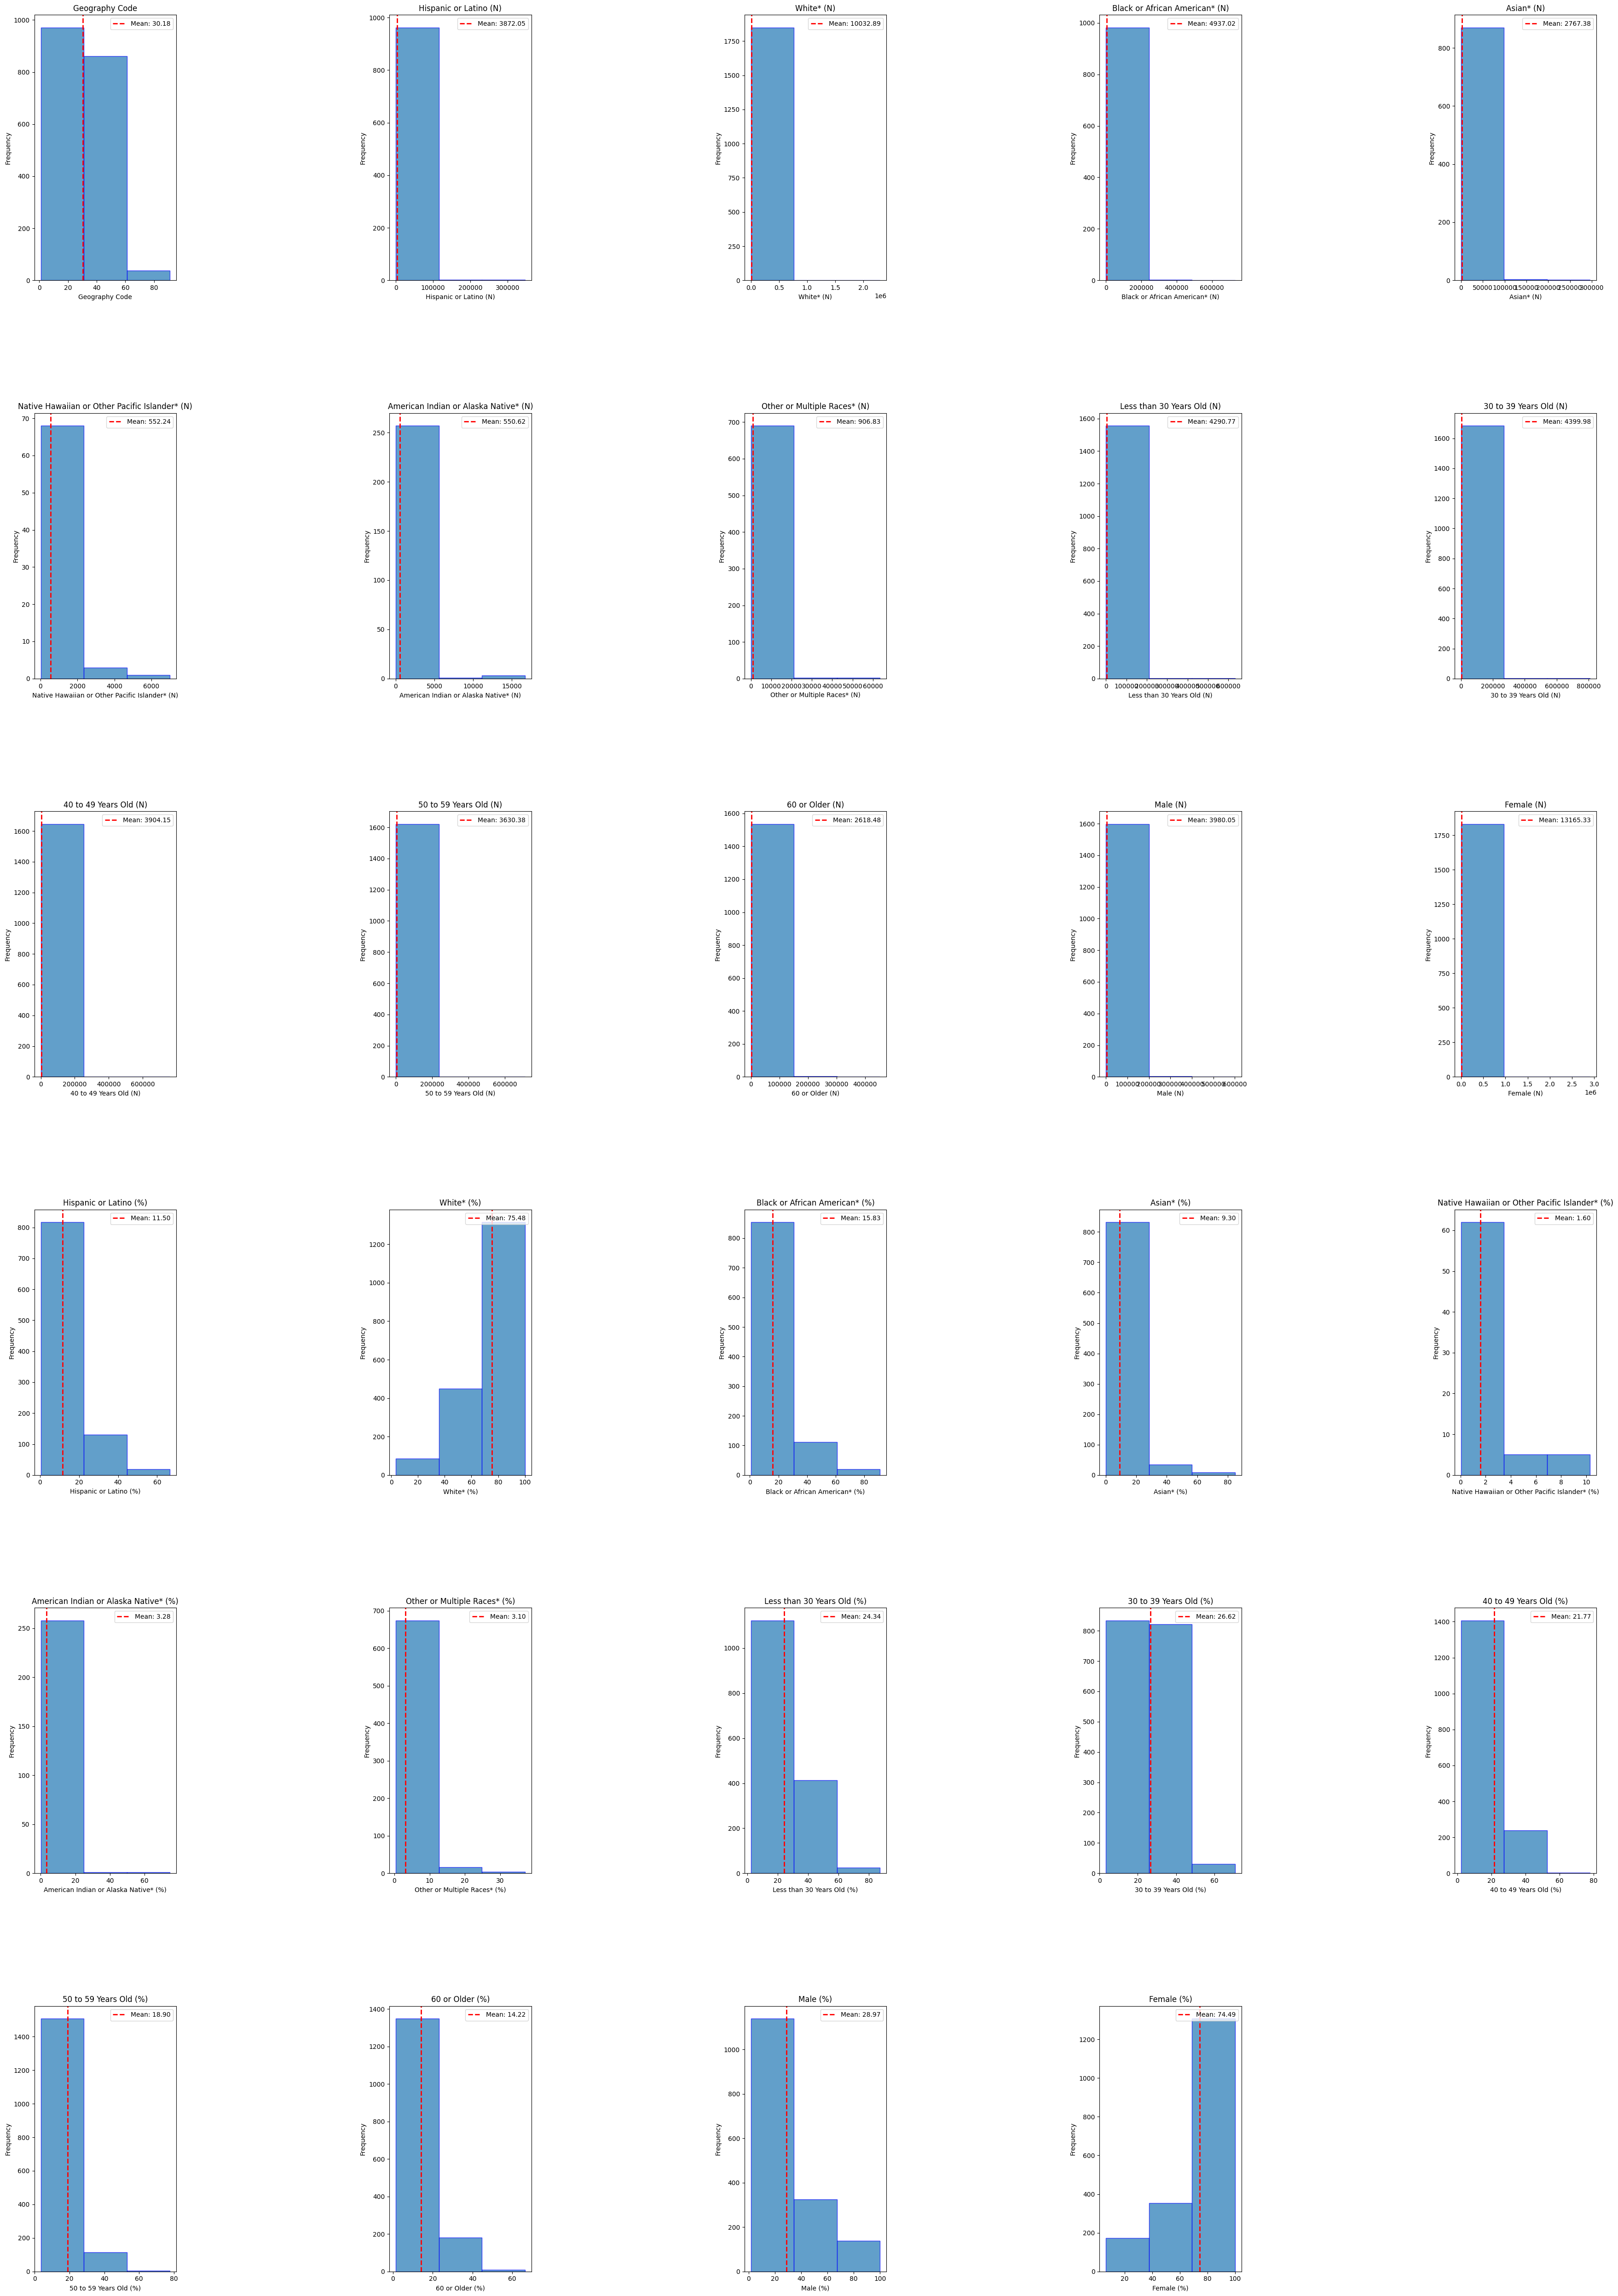

In [43]:
#Call ahrf_noTotal's `hist` method to plot histograms of each of the numeric features
#params = {'axes.titlesize':'32',
#          'xtick.labelsize':'24',
#          'ytick.labelsize':'24'}
#mplt.rcParams.update(params)
#ahrf_noTotal.hist(bins=3,figsize=(20,50))
#plt.tight_layout()
#plt.subplots_adjust(hspace=0.5,wspace=1.5);

plot_numeric_histograms(ahrf_noTotal,3)

#Hint: notice how the terminating ';' "swallows" some messy output and leads to a tidier notebook

In [44]:
#Removing spaces in column names. 
ahrf_dataND = ahrf_data.columns.str.replace(' ','_')

In [45]:
ahrf_noTotal.head().T

,0,1,2,3,4
Area Health Resource Files Release Year,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019
Occupation Code,D3256,D3256,D3256,D3256,D3256
Occupation Name,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...
Geography Code,1,2,4,5,6
Geography Abbreviation,AL,AK,AZ,AR,CA
Geography Name,Alabama,Alaska,Arizona,Arkansas,California
Hispanic or Latino (N),NaN,NaN,478.0,NaN,1364.0
White* (N),3989.0,643.0,2998.0,1655.0,7661.0
Black or African American* (N),418.0,NaN,125.0,146.0,826.0
Asian* (N),81.0,NaN,193.0,NaN,3169.0


In [46]:
#Filter the 30 to 39 column for values > 20000
ahrf_noTotal[ahrf_noTotal['30 to 39 Years Old (N)']> 300000].T
#ahrf_data['30 to 39 Years Old (N)']

,883,1663
Area Health Resource Files Release Year,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019
Occupation Code,D3601,D3255
Occupation Name,"Nursing, Psychiatric and Home Health Aides",Registered Nurses
Geography Code,91,91
Geography Abbreviation,US,US
Geography Name,All States,All States
Hispanic or Latino (N),346402.0,237454.0
White* (N),877814.0,2296253.0
Black or African American* (N),730399.0,367880.0
Asian* (N),111946.0,296085.0


<div class="alert alert-block alert-info"><h3>  It is evident that dropping the Total Count column is not enough. We will drop all rows in the data set with Geography code 91, which represents all states. </h3><br><h4>We don't want this data to make it look like there are some anomalies or outliers.</h4></div>

In [47]:
ahrf_NoUS = ahrf_noTotal.drop(ahrf_noTotal[ahrf_noTotal['Geography Code'] == 91].index)

<div class="alert alert-block alert-info"><h3>Now for some cleanup to make viewing easier.</h3></div>

In [48]:
def clean_column_names(df):
    """Converts column names to lowercase and removes special characters.

    Args:
        df: The input Pandas DataFrame.

    Returns:
        A new Pandas DataFrame with cleaned column names.  Does *not* modify the original DataFrame.
    """

    cleaned_columns = []
    for col in df.columns:
        new_col = col.lower()  # Convert to lowercase

        # Remove (N) and preceding space
        new_col = re.sub(r"\s*\(n\)", "", new_col)  # Case-insensitive (n) removal
        new_col = new_col.replace(" ", "_")  # Replace spaces with underscores
        new_col = re.sub(r'[^a-zA-Z0-9_%]+', '', new_col)  # Remove special chars (except %)
        new_col = new_col.replace('60_or_older','60+')
        new_col = new_col.replace('_old','')
        new_col = new_col.replace('_or_','-') 
        #This one might confuse if the reader does not fully understand the data set. We are removing _Years. The idea is to have the resulting data set produce short column names. 
        new_col = new_col.replace('_years','') 
        

       

        new_col = new_col.replace(" ", "_")  # Replace spaces with underscores
        cleaned_columns.append(new_col)

    df_cleaned = df.copy()
    df_cleaned.columns = cleaned_columns
    return df_cleaned

# Example usage:
ahrf_NoUS_cleaned = clean_column_names(ahrf_NoUS)


In [49]:
ahrf_NoUS_cleaned.head().T

,0,1,2,3,4
area_health_resource_files_release_year,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019
occupation_code,D3256,D3256,D3256,D3256,D3256
occupation_name,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...
geography_code,1,2,4,5,6
geography_abbreviation,AL,AK,AZ,AR,CA
geography_name,Alabama,Alaska,Arizona,Arkansas,California
hispanic-latino,NaN,NaN,478.0,NaN,1364.0
white,3989.0,643.0,2998.0,1655.0,7661.0
black-african_american,418.0,NaN,125.0,146.0,826.0
asian,81.0,NaN,193.0,NaN,3169.0


<div class="alert alert-block alert-info"><h3> We still see long column names for race. </h3>
Let's use the following short names:<br>
<b>Indigenous</b>: American Indian or Alaska Native <br>
<b>Black</b>: Black or African American <br>
<b>Pacific</b>: Native Hawaiian or Other Pacific Islander <br>
<b>White</b>: White <br>
<b>Asiian</b>: Asian <br>
<b>Hispanic</b>: Hispanic or Latino <br>
<b>Other</b>: Other or Multiple Races</div>

In [50]:
# Rename specific columns in the *cleaned* DataFrame
ahrf_NoUS_cleaned = ahrf_NoUS_cleaned.rename(columns={
    'hispanic-latino': 'hispanic',  # Use the *cleaned* column names!
    'white': 'white',
    'black-african_american': 'black',
    'asian': 'asian',
    'native_hawaiian-other_pacific_islander': 'pacific',
    'american_indian-alaska_native': 'indigenous',
    'other-multiple_races': 'other'
})

In [51]:
ahrf_NoUS_cleaned.columns

Index(['area_health_resource_files_release_year', 'occupation_code',
       'occupation_name', 'geography_code', 'geography_abbreviation',
       'geography_name', 'hispanic', 'white', 'black', 'asian', 'pacific',
       'indigenous', 'other', 'less_than_30', '30_to_39', '40_to_49',
       '50_to_59', '60+', 'male', 'female', 'hispanic-latino_%', 'white_%',
       'black-african_american_%', 'asian_%',
       'native_hawaiian-other_pacific_islander_%',
       'american_indian-alaska_native_%', 'other-multiple_races_%',
       'less_than_30_%', '30_to_39_%', '40_to_49_%', '50_to_59_%', '60+_%',
       'male_%', 'female_%', 'missing-suppressed_raceethnicity_data_comment',
       'missing-suppressed_age_data_comment',
       'missing-suppressed_gender_data_comment',
       'hrsa_data_warehouse_processing_date', 'unnamed_39'],
      dtype='object')

<div class="alert alert-block alert-info">We will drop columns that have no use for us. <br><br> Some are columns for the same item in different forms. For example, geo code, geo name and geo abbreviation.</div>

In [52]:
ahrf_NoUS_cleaned = ahrf_NoUS_cleaned.drop(columns=['occupation_code', 'geography_code', 'geography_abbreviation'])

In [53]:
print(ahrf_NoUS_cleaned['unnamed_39'].notnull().sum()," ", ahrf_NoUS_cleaned['unnamed_39'].isnull().sum())

0   1832


<div class="alert alert-block alert-info">unnamed _39 column is nothing but null values. We are doping it. </div>

In [54]:
ahrf_NoUS_cleaned = ahrf_NoUS_cleaned.drop(columns=['unnamed_39'])

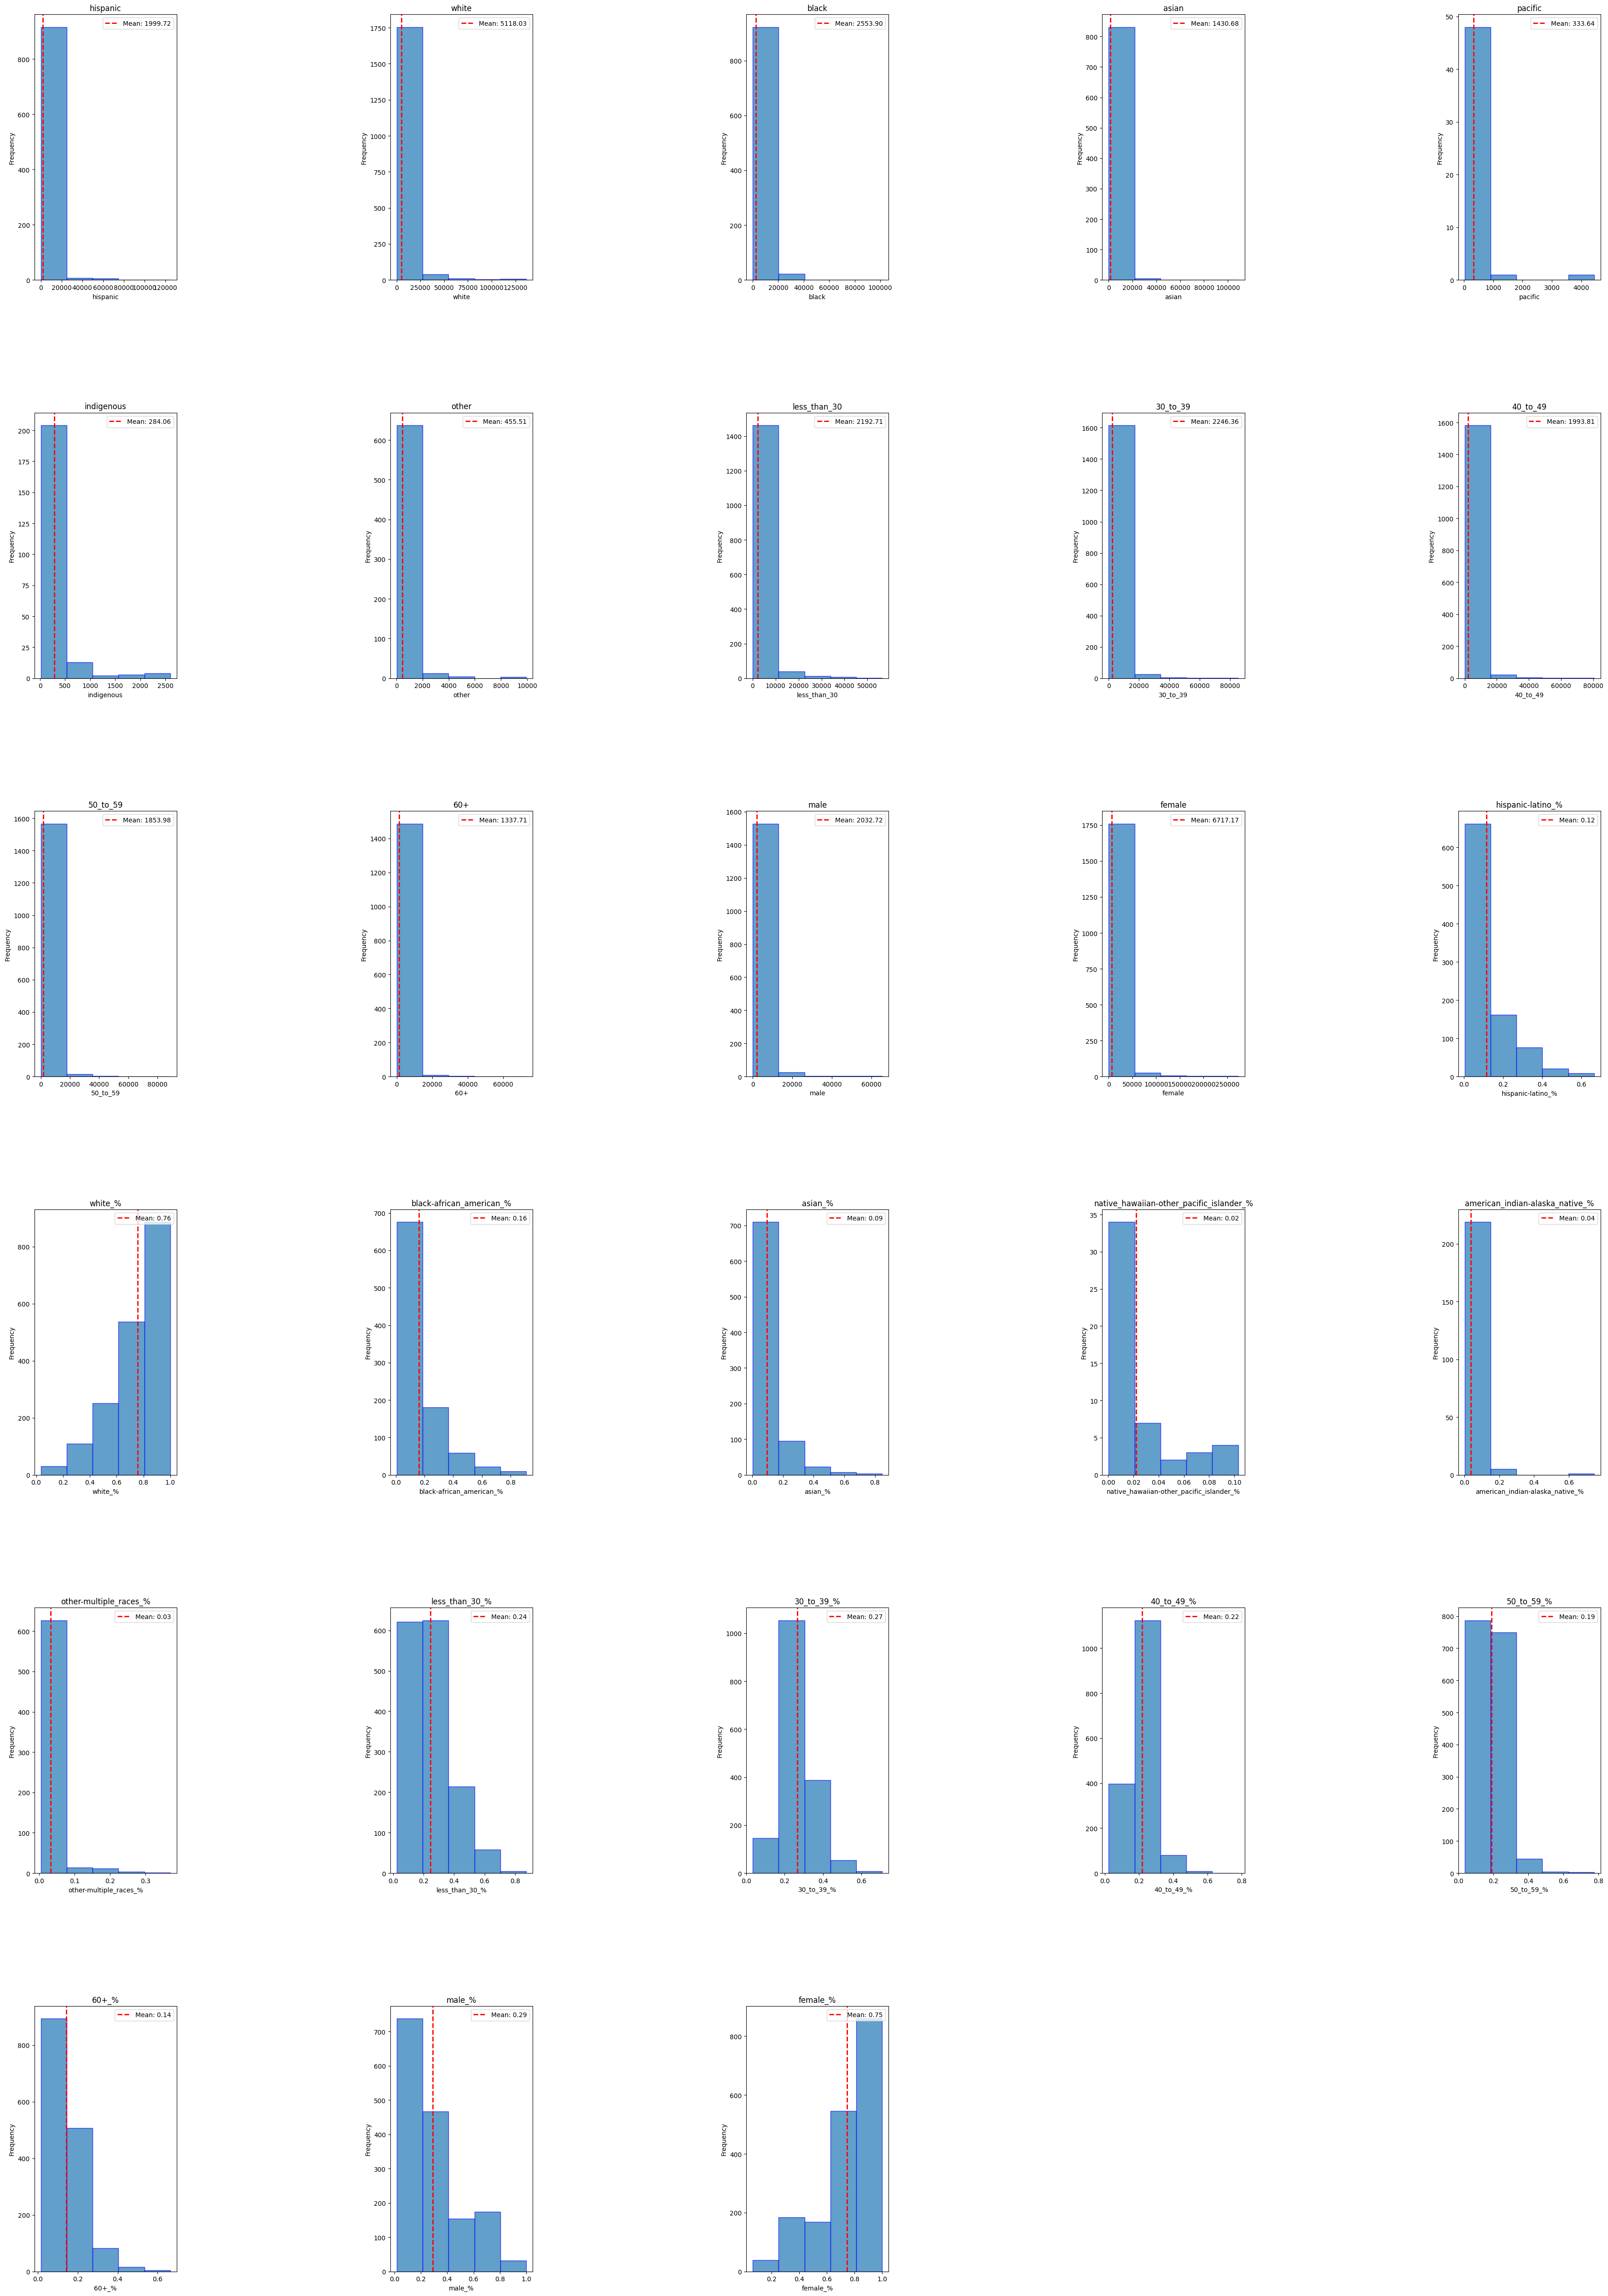

In [55]:
plot_numeric_histograms(ahrf_NoUS_cleaned)

<div class="alert alert-block alert-info"><h3>  Time to start identifying some anomalies or outliers. </h3></div>

In [56]:
#Filter the 30 to 39 column for values > 300000
ahrf_NoUS_cleaned[ahrf_NoUS_cleaned['30_to_39']> 50000].T
#ahrf_data['30 to 39 Years Old (N)']

,1096,1616,1621,1655
area_health_resource_files_release_year,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019
occupation_name,Personal Care Aides,Registered Nurses,Registered Nurses,Registered Nurses
geography_name,California,California,Florida,Texas
hispanic,124913.0,46989.0,34471.0,48792.0
white,86986.0,136361.0,121503.0,127624.0
black,37915.0,22195.0,37677.0,36891.0
asian,73466.0,108602.0,14538.0,29112.0
pacific,4439.0,798.0,NaN,108.0
indigenous,1324.0,604.0,491.0,636.0
other,8125.0,9934.0,4705.0,4142.0


<div class="alert alert-block alert-info">Florida and California are largely populated states. This appears to be normal and not an error-prone data. </div>

<div class="alert alert-block alert-info">Let's look at the distribution of 30-39</div>

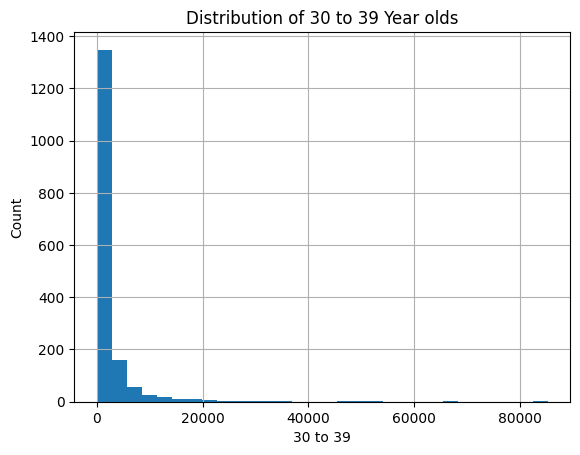

In [57]:
ahrf_NoUS_cleaned['30_to_39'].hist(bins=30)
plt.xlabel('30 to 39')
plt.ylabel('Count')
plt.title('Distribution of 30 to 39 Year olds');

<div class="alert alert-block alert-info"><h3> We should not ignore the outlier because they represent populated areas </h3></div>

<div class="alert alert-block alert-info">We will assume all long tail distribution are a result of population size (at least for now)<br>

</div>

<div class="alert alert-block alert-info"><h3> Derive State-wide Summary Statistics For The Race and Gender Segment</h3></div>

In [58]:
# Define aggregation functions for race columns dynamically
race_col_names = ['indigenous','black','pacific', 'white', 'asian', 'hispanic', 'other','male','female']
race_aggregations = {f"state_total_{col}": pd.NamedAgg(column=col, aggfunc='sum') for col in race_col_names}

# Manually include 'Occupation_name' aggregation
state_summary = ahrf_NoUS_cleaned.groupby('geography_name').agg(
    occupation_per_state=pd.NamedAgg(column='occupation_name', aggfunc='size'),
    **race_aggregations  # Unpack dynamically generated aggregations
).reset_index()
state_summary.head()

,geography_name,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female
0,Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0
1,Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0
2,Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0
3,Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0
4,California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0


<div class="alert alert-block alert-info"><h3> Since we made an assumption about outliers and population, let's get the US Population Data</h3></div>

In [59]:
#Use pandas' `read_html` method to read the table from the URL below
states_url = 'https://simple.wikipedia.org/w/index.php?title=List_of_U.S._states&oldid=7168473'
usa_states = pd.read_html(states_url)

In [60]:
type(usa_states)

list

In [61]:
len(usa_states)

1

In [62]:
usa_states = usa_states[0]

In [63]:
usa_states.head()

Name & postal abbs. [1]                                 Cities               \
  Name & postal abbs. [1] Name & postal abbs. [1].1      Capital   Largest[5]   
0                 Alabama                        AL   Montgomery   Birmingham   
1                  Alaska                        AK       Juneau    Anchorage   
2                 Arizona                        AZ      Phoenix      Phoenix   
3                Arkansas                        AR  Little Rock  Little Rock   
4              California                        CA   Sacramento  Los Angeles   

  Established[A] Population [B][3] Total area[4]          Land area[4]  \
  Established[A] Population [B][3]           mi2      km2          mi2   
0   Dec 14, 1819           4903185         52420   135767        50645   
1    Jan 3, 1959            731545        665384  1723337       570641   
2   Feb 14, 1912           7278717        113990   295234       113594   
3   Jun 15, 1836           3017804         53179   137732        52035   
4    Sep 9, 1850          39512223        163695   423967       155779   

           Water area[4]         Number of Reps.  
       km2           mi2     km2 Number of Reps.  
0   131171          1775    4597               7  
1  1477953         94743  245384               1  
2   294207           396    1026               9  
3   134771          1143    2961               4  
4   403466          7916   20501              53

In [64]:
type(usa_states)

pandas.core.frame.DataFrame

In [65]:
#Use the iloc accessor to get the pandas Series for column number 4 from `usa_states`
#It should be a column of dates
established = usa_states.iloc[:, 4]

In [66]:
#Now use the iloc accessor again to extract columns 0, 5, and 6 and the dataframe's `copy()` method
#Set the names of these extracted columns to 'state', 'state_population', and 'state_area_sq_miles',
#respectively.
usa_states_sub = usa_states.iloc[:, [0,5,6]].copy()
usa_states_sub.columns = ['state','state_population','state_area_sq_miles']
usa_states_sub.head()

,state,state_population,state_area_sq_miles
0,Alabama,4903185,52420
1,Alaska,731545,665384
2,Arizona,7278717,113990
3,Arkansas,3017804,53179
4,California,39512223,163695


In [67]:
state_summary.columns

Index(['geography_name', 'occupation_per_state', 'state_total_indigenous',
       'state_total_black', 'state_total_pacific', 'state_total_white',
       'state_total_asian', 'state_total_hispanic', 'state_total_other',
       'state_total_male', 'state_total_female'],
      dtype='object')

In [68]:
missing_states = set(state_summary['geography_name']) - set(usa_states_sub.state)
missing_states

{'District of Columbia',
 'Hawaii',
 'Kentucky',
 'Massachusetts',
 'Pennsylvania',
 'Rhode Island',
 'Virginia'}

In [69]:
#usa_states_sub.state[usa_states_sub.state.str.contains(missing_states)]
# Join the missing states into a regular expression pattern (escaped for special characters)
missing_states_pattern = '|'.join([re.escape(state) for state in missing_states])

# Filter rows from usa_states_sub where state contains any of the missing states
filtered_states = usa_states_sub[usa_states_sub.state.str.contains(missing_states_pattern, regex=True)]
filtered_states


,state,state_population,state_area_sq_miles
16,Kentucky[C],4467673,40408
20,Massachusetts[C],6892503,10554
37,Pennsylvania[C],12801989,46054
38,Rhode Island[D],1059361,1545
45,Virginia[C],8535519,42775
47,West Virginia,1792147,24230


In [70]:
usa_states_sub.state.replace(to_replace='\[.*\]', value='', regex=True, inplace=True)

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
C:\Users\binia\AppData\Local\Temp\ipykernel_80784\2653189839.py:1: SyntaxWarning: invalid escape sequence '\['
  usa_states_sub.state.replace(to_replace='\[.*\]', value='', regex=True, inplace=True)


In [71]:
# Join the missing states into a regular expression pattern (escaped for special characters)
missing_states_pattern = '|'.join([re.escape(state) for state in missing_states])

# Filter rows from usa_states_sub where state contains any of the missing states
filtered_states = usa_states_sub[usa_states_sub.state.str.contains(missing_states_pattern, regex=True)]
filtered_states

,state,state_population,state_area_sq_miles
16,Kentucky,4467673,40408
20,Massachusetts,6892503,10554
37,Pennsylvania,12801989,46054
38,Rhode Island,1059361,1545
45,Virginia,8535519,42775
47,West Virginia,1792147,24230


In [72]:
missing_states = set(state_summary['geography_name']) - set(usa_states_sub.state)
missing_states

{'District of Columbia', 'Hawaii'}

In [73]:
state_summary.head()

,geography_name,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female
0,Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0
1,Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0
2,Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0
3,Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0
4,California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0


In [74]:
usa_states_sub.head(12)

,state,state_population,state_area_sq_miles
0,Alabama,4903185,52420
1,Alaska,731545,665384
2,Arizona,7278717,113990
3,Arkansas,3017804,53179
4,California,39512223,163695
5,Colorado,5758736,104094
6,Connecticut,3565278,5543
7,Delaware,973764,2489
8,Florida,21477737,65758
9,Georgia,10617423,59425


In [75]:
# Replace 'Hawai\'i' with 'Hawaii' in the 'state' column
usa_states_sub['state'] = usa_states_sub['state'].replace("Hawaiʻi", "Hawaii")

# Create a new row for 'District of Columbia' 
new_row = pd.DataFrame({
    'state': ['District of Columbia'],
    # Add columns here with default values from the web
    'state_population': [705749],  
    'state_area_sq_miles': [68.34],  
    # Add other columns similarly...
})

# Check if 'District of Columbia' already exists in the state column
if 'District of Columbia' not in usa_states_sub['state'].values:
    # Append the new row to the original DataFrame
    usa_states_sub = pd.concat([usa_states_sub, new_row], ignore_index=True)

In [76]:
usa_states_sub.tail()

,state,state_population,state_area_sq_miles
46,Washington,7614893,71298.00
47,West Virginia,1792147,24230.00
48,Wisconsin,5822434,65496.00
49,Wyoming,578759,97813.00
50,District of Columbia,705749,68.34


In [77]:
missing_states = set(state_summary['geography_name']) - set(usa_states_sub.state)
missing_states

set()

<div class="alert alert-block alert-info"><h3> Better! We have an empty set for missing states now. We can confidently add the population and state area columns to the ski resort data.</h3></div>

In [78]:
#Use 'state_summary's `merge()` method to combine our new data in 'usa_states_sub'
#specify the arguments how='left' and on='state'
# Check if the columns from usa_states_sub are already in state_summary
if 'state_population' not in state_summary.columns or 'state_area_sq_miles' not in state_summary.columns:
    # Merge state_summary with usa_states_sub using appropriate column names
    state_summary = state_summary.merge(usa_states_sub, how='left', left_on='geography_name', right_on='state', suffixes=('', ''))

#state_summary = state_summary.merge(usa_states_sub, how='left', left_on='Geography_Name', right_on='state',suffixes=('', ''))
state_summary.head(12)

,geography_name,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,state,state_population,state_area_sq_miles
0,Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,Alabama,4903185,52420.00
1,Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0,Alaska,731545,665384.00
2,Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0,Arizona,7278717,113990.00
3,Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0,Arkansas,3017804,53179.00
4,California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0,California,39512223,163695.00
5,Colorado,36,1098.0,10372.0,97.0,182866.0,9117.0,38637.0,4572.0,55033.0,194194.0,Colorado,5758736,104094.00
6,Connecticut,37,202.0,34622.0,0.0,119800.0,9362.0,25717.0,3277.0,38216.0,156991.0,Connecticut,3565278,5543.00
7,Delaware,35,89.0,12322.0,0.0,29996.0,1388.0,1120.0,305.0,8832.0,38457.0,Delaware,973764,2489.00
8,District of Columbia,31,0.0,26579.0,0.0,14941.0,3541.0,2381.0,509.0,12053.0,37334.0,District of Columbia,705749,68.34
9,Florida,37,911.0,207422.0,286.0,449757.0,46288.0,193959.0,16582.0,204098.0,712649.0,Florida,21477737,65758.00


<div class="alert alert-block alert-info"><h3>Target Feature</h3></div>

Text(0.5, 1.0, 'Scatter Plot: Male vs Female Population with Occupation per State (Size)')

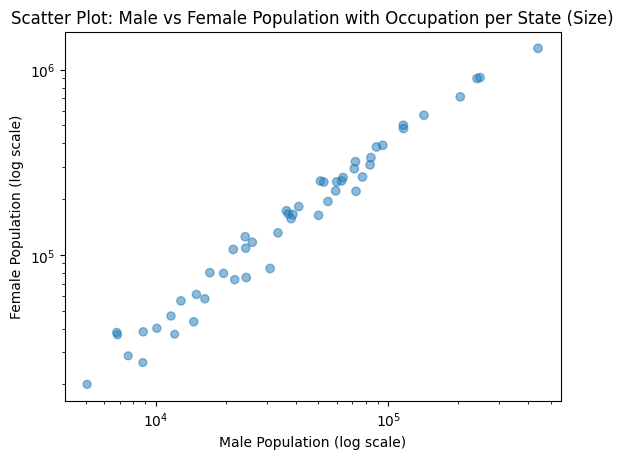

In [79]:
#Scatter plot with log scale on both axes
ax = state_summary.plot(x='state_total_male', y='state_total_female', kind='scatter', 
                        s=state_summary['occupation_per_state'],  # Third dimension represented by size
                        alpha=0.5)  # Optional: Adjust transparency

# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Optionally, set labels and title
ax.set_xlabel('Male Population (log scale)')
ax.set_ylabel('Female Population (log scale)')
ax.set_title('Scatter Plot: Male vs Female Population with Occupation per State (Size)')

In [80]:
#Use the loc accessor on ahrf_NoUS_cleaned to print the 'Geography_Name', 'Male' and 'Female' columns for Black only
ahrf_NoUS_cleaned.loc[~ahrf_NoUS_cleaned['black'].isnull() , ['geography_name','male', 'female']]

,geography_name,male,female
0,Alabama,860.0,3686.0
2,Arizona,755.0,3197.0
3,Arkansas,351.0,1498.0
4,California,2052.0,11505.0
6,Connecticut,292.0,2238.0
...,...,...,...
1892,Maryland,215.0,1116.0
1904,New York,575.0,3048.0
1905,North Carolina,246.0,1948.0
1915,Texas,798.0,2740.0


<div class="alert alert-block alert-info"><h3>Even though Femal is more likely to have more missing data, we cannot drop this column because as we saw earlier that Female account for the majority of the data.</h3><br>Let's check for missing values by row by Black.</div>

In [81]:
# Get the count and percentage of missing values for the 'Black' column
#missing_count = pd.Series([ahrf_NoUS['Black'].isnull().sum()], index=['count'])
#missing_percentage = pd.Series([100 * ahrf_NoUS['Black'].isnull().mean()], index=['%'])

# Concatenate the two Series into a DataFrame
#missing = pd.concat([missing_count, missing_percentage], axis=1)

#missing = pd.concat([ahrf_NoUS['Black'].isnull().sum(axis=0), 
#                     100 * ahrf_NoUS['Black'].isnull().mean(axis=0)], 
#                    axis=1)
#missing.columns=['count', '%']
#missing.sort_values(by='count', ascending=False).head(10)
#missing.T

# Calculate missing values for each row in the 'Black' column
missing_count = ahrf_NoUS_cleaned['black'].isnull().astype(int)  # 1 for missing, 0 for not missing
missing_percentage = missing_count * 100  # Convert count to percentage (0 or 100)

# Combine count and percentage into a DataFrame
missing = pd.DataFrame({
    'count': missing_count,
    '%': missing_percentage
})

# Sort the rows by the 'count' column in descending order
missing_sorted = missing.sort_values(by='count', ascending=False)
missing_sorted.head(10)


,count,%
1903,1,100
1902,1,100
1921,1,100
1901,1,100
1,1,100
19,1,100
17,1,100
16,1,100
15,1,100
14,1,100


In [82]:
missing['%'].unique()

array([  0, 100])

<div class="alert alert-block alert-info"><h3>It looks like we have a clean dataset</h3><h4>Let's Save the data</h4>Save this to data directory, separately. Note that the original data is in raw_data and we will save derived data in a separate location. This guards against overwriting the  original data.
</div>

In [83]:
ahrf_NoUS_cleaned.shape

(1832, 35)

In [88]:
ahrf_NoUS_cleaned.head()

,area_health_resource_files_release_year,occupation_name,geography_name,hispanic,white,black,asian,pacific,indigenous,other,...,30_to_39_%,40_to_49_%,50_to_59_%,60+_%,male_%,female_%,missing-suppressed_raceethnicity_data_comment,missing-suppressed_age_data_comment,missing-suppressed_gender_data_comment,hrsa_data_warehouse_processing_date
0,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Alabama,NaN,3989.0,418.0,81.0,NaN,NaN,NaN,...,34.294,24.747,21.755,7.567,18.918,81.082,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN,2022/03/21
1,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Alaska,NaN,643.0,NaN,NaN,NaN,NaN,NaN,...,44.706,30.065,NaN,17.124,NaN,98.954,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed,2022/03/21
2,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Arizona,478.0,2998.0,125.0,193.0,NaN,NaN,122.0,...,29.833,24.595,24.949,18.219,19.104,80.896,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21
3,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Arkansas,NaN,1655.0,146.0,NaN,NaN,NaN,NaN,...,33.045,25.690,24.013,13.196,18.983,81.017,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN,2022/03/21
4,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,California,1364.0,7661.0,826.0,3169.0,NaN,NaN,469.0,...,30.619,22.077,21.553,19.068,15.136,84.864,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21


In [89]:
# save the state_summary separately.
datapath = '../data'
# Specify the file path
file_path = f'{datapath}/state_summary.csv'
state_summary.to_csv(file_path, index=False)

# Save the DataFrame to CSV
file_path2 = f'{datapath}/occupation_by_state_gender_race.csv'
ahrf_NoUS_cleaned.to_csv(file_path2, index=False)
#save_file(state_summary, 'state_summary.csv', datapath)

<div class="alert alert-block alert-info"><h2>We are ready to move to EDA. <br><br>After further investigation of the mortality data, we will have difficulty merging our state_summary df with the mortality df since it is meeting the important geo information. We might have a use later on if gender and race need to be investigated with regard to mortality in order to support or oppose our hypothesis.</h2></div>